<a href="https://colab.research.google.com/github/ee17b031-iittp/DeepSAT-6-Satellite-Image-Classification/blob/master/deepsat_6_resnet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $ Importing \, Dependencies $ #

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import xlrd
import pandas as pd
import scipy as sp
import io
from math import sqrt
from math import pi
from math import exp
from google.colab.patches import cv2_imshow
from sklearn.manifold import TSNE
import os
import glob
from sklearn.model_selection import StratifiedKFold
import scipy.io as sio
import plotly.graph_objects as go
from PIL import Image
# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve,f1_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from skimage import data
import seaborn as sns; sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.regularizers import l1,l2
from keras.engine import Model
from keras import callbacks
from keras import optimizers
from keras.applications import resnet50 as resn
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization,Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.regularizers import l2
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras import backend as K
from keras.callbacks import *
import tensorflow as tf

Using TensorFlow backend.


#$ Loading \, Dataset$#

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
file_path='/content/gdrive/My Drive/deepsat-sat6/'

In [ ]:
#importing_datasets
x_train = pd.read_csv(file_path+'X_train_sat6.csv',header=None) #This will kill the available memory on the kaggle machine :\
y_train = pd.read_csv(file_path+'y_train_sat6.csv',header=None)
x_train = x_train.values.reshape(x_train.shape[0],28,28,4).astype(np.float32)
y_train = y_train.values.astype(np.float32)

x_test = pd.read_csv(file_path+'X_test_sat6.csv',header=None)
y_test = pd.read_csv(file_path+'y_test_sat6.csv',header=None)
x_test = x_test.values.reshape(x_test.shape[0],28,28,4).astype(np.float32)
y_test = y_test.values.astype(np.float32)

# $Train-Val \, Split $

In [ ]:
#train-val split
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

#$ Data \, Preprocessing$#

In [ ]:
#preprocessing
dim=(32,32)
x_train =np.array([cv2.resize(x, dim, interpolation = cv2.INTER_AREA) for x in x_train])
x_val = np.array([cv2.resize(x, dim, interpolation = cv2.INTER_AREA) for x in x_val])
x_test = np.array([cv2.resize(x, dim, interpolation = cv2.INTER_AREA) for x in x_test])

In [ ]:
#not using the fourth channel-NIR
x_train=x_train[:,:,:,0:3]
x_val=x_val[:,:,:,0:3]
x_test=x_test[:,:,:,0:3]

In [ ]:
means=np.mean(x_train,axis=0)
x_train=(x_train-means)/255
x_test=(x_test-means)/255
x_val=(x_val-means)/255

#$Cyclic \, Learning \, Rate$#

In [ ]:
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

#$ One\, Cycle \, Policy$#

In [ ]:
# Implement One Cycle Policy Algorithm in the Keras Callback Class
class Onecycle(keras.callbacks.Callback):
    
    def __init__(self,base_lr, max_lr, step_size, base_m, max_m, cyclical_momentum):
 
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.base_m = base_m
        self.max_m = max_m
        self.cyclical_momentum = cyclical_momentum
        self.step_size = step_size
        
        self.clr_iterations = 0.
        self.cm_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        
    def clr(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)          
            return self.base_lr-(self.base_lr-self.base_lr/100)*np.maximum(0,(1-x))
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0,(1-x))
    
    def cm(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1) 
            return self.max_m
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.max_m - (self.max_m-self.base_m)*np.maximum(0,(1-x))
        
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
            
        if self.cyclical_momentum == True:
            if self.clr_iterations == 0:
                K.set_value(self.model.optimizer.momentum, self.cm())
            else:
                K.set_value(self.model.optimizer.momentum, self.cm())
            
            
    def on_batch_begin(self, batch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        
        if self.cyclical_momentum == True:
            self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
        if self.cyclical_momentum == True:
            K.set_value(self.model.optimizer.momentum, self.cm())
            

#$ Learning \, Range \, Test $#
$ For \, completely \, freezed \, model \, (pre-trained \, layers) \, with \, an \, added \, classifier \, block$

In [ ]:
base_model = resn.ResNet50(weights='imagenet', 
                       include_top=False, 
                       input_shape=(32, 32, 3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning:

The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.



94658560/94653016 [==============================] - 1s 0us/step


In [ ]:
last = base_model.layers[-1].output

In [ ]:
last=GlobalAveragePooling2D()(last)
last=Dense(512,name='dense_top_1')(last)
x=BatchNormalization(name='batch_norm_top_1')(last)
x=Activation('relu',name='activation_top_1')(x)
x=Dense(256,name='dense_top_2')(x)
x=BatchNormalization(name='batch_norm_top_2')(x)
x=Activation('relu',name='activation_top_2')(x)
pred=Dense(6, activation='softmax',name='dense_top_3')(x)
new_model=Model(base_model.input,pred)

In [ ]:
for layer in new_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
for i in range(-7,0):
  new_model.layers[i].trainable = True

In [ ]:
for layer in new_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f21a0a42400> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f21a0a42b38> False
<keras.layers.convolutional.Conv2D object at 0x7f21a0a429b0> False
<keras.layers.normalization.BatchNormalization object at 0x7f21a0a42c50> True
<keras.layers.core.Activation object at 0x7f21a0a42d30> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f21a0a42780> False
<keras.layers.pooling.MaxPooling2D object at 0x7f21a07d3128> False
<keras.layers.convolutional.Conv2D object at 0x7f21a07d3f28> False
<keras.layers.normalization.BatchNormalization object at 0x7f21a03685f8> True
<keras.layers.core.Activation object at 0x7f21a0a36e48> False
<keras.layers.convolutional.Conv2D object at 0x7f21a0a0f588> False
<keras.layers.normalization.BatchNormalization object at 0x7f21862f87f0> True
<keras.layers.core.Activation object at 0x7f21862fdf60> False
<keras.layers.convolutional.Conv2D object at 0x7f2186314e10> False
<keras.layers.convolutional.

In [ ]:
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
new_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
clr = CyclicLR(base_lr=1e-5, max_lr=3,
                        step_size=4*2295)

In [ ]:
history = new_model.fit(x_train,
                        y_train, 
                        batch_size=120, 
                        epochs=4,
                        validation_data=(x_val,y_val),
                        callbacks=[clr], 
                        verbose=1)

Train on 275400 samples, validate on 48600 samples
Epoch 1/4
275400/275400 [==============================] - 1245s 5ms/step - loss: 0.5511 - accuracy: 0.8897 - val_loss: 1.1069 - val_accuracy: 0.5578
Epoch 2/4
275400/275400 [==============================] - 1217s 4ms/step - loss: 3.6640 - accuracy: 0.3799 - val_loss: 1.5396 - val_accuracy: 0.3714
Epoch 3/4
275400/275400 [==============================] - 1186s 4ms/step - loss: 1.5099 - accuracy: 0.3369 - val_loss: 1.4777 - val_accuracy: 0.3150
Epoch 4/4
275400/275400 [==============================] - 1156s 4ms/step - loss: 12.3235 - accuracy: 0.3368 - val_loss: 11.0132 - val_accuracy: 0.3714


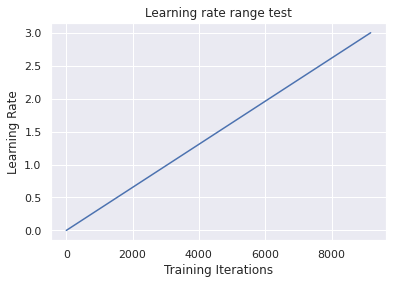

In [ ]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("Learning rate range test")
plt.plot(clr.history['iterations'], clr.history['lr'])

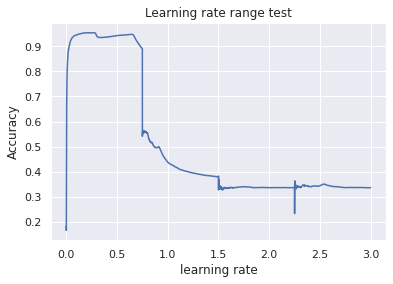

In [ ]:
h = clr.history
lr = h['lr']
acc = h['accuracy']
plt.xlabel('learning rate')
plt.ylabel('Accuracy')
plt.title("Learning rate range test")
plt.plot(lr,acc)

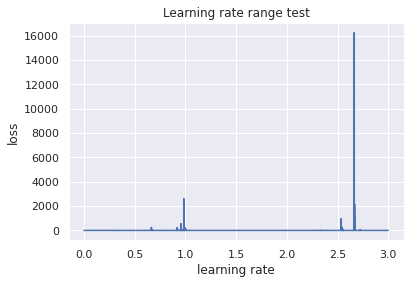

In [ ]:
loss=h['loss']
lr = h['lr']
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.title("Learning rate range test")
plt.plot(lr,loss)

In [ ]:
for i in range(5000):
  print(lr[i],acc[i])

Streaming output truncated to the last 5000 lines.
0.0003367963 0.16666667
0.0006635926 0.2
0.0009903889 0.26458332
0.0013171852 0.345
0.0016439814 0.4097222
0.0019707778 0.47142857
0.0022975742 0.51875
0.0026243704 0.55833334
0.0029511666 0.5966667
0.003277963 0.6242424
0.0036047592 0.64513886
0.0039315554 0.6653846
0.004258352 0.68154764
0.0045851483 0.6988889
0.0049119443 0.7104167
0.0052387407 0.7245098
0.005565537 0.73333335
0.005892333 0.74473685
0.0062191295 0.7554167
0.006545926 0.7638889
0.0068727224 0.77007574
0.0071995184 0.776087
0.007526315 0.7826389
0.007853111 0.78833336
0.008179908 0.79391026
0.008506704 0.79691356
0.0088335 0.8020833
0.009160296 0.80574715
0.0094870925 0.80972224
0.009813889 0.81344086
0.010140685 0.8184896
0.010467482 0.82171714
0.010794278 0.8257353
0.011121074 0.8290476
0.01144787 0.83148146
0.011774667 0.8333333
0.012101463 0.8364035
0.0124282595 0.83995724
0.012755056 0.84229165
0.013081851 0.8441057
0.013408648 0.8460317
0.013735444 0.8492248
0.0

In [ ]:
slope=np.zeros(len(acc)-1)
for i in range(len(acc)-1):
  slope[i]=((loss[i+1]-loss[i])/(lr[i+1]-lr[i]));

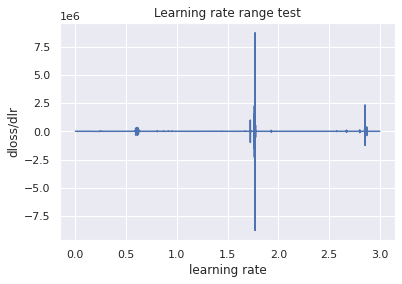

In [ ]:
plt.xlabel('learning rate')
plt.ylabel('dloss/dlr')
plt.title("Learning rate range test")
plt.plot(lr[0:len(acc)-1],slope)


#$ Training \, the \, model $#
$ Here \, all \, the \, layers \, of \, the \, pretrained \, model \, are \, frozen$

In [ ]:
base_model = resn.ResNet50(weights='imagenet', 
                       include_top=False, 
                       input_shape=(32, 32, 3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning:

The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.



In [ ]:
last = base_model.layers[-1].output

In [ ]:
last=GlobalAveragePooling2D()(last)
last=Dense(512,name='dense_top_1')(last)
x=BatchNormalization(name='batch_norm_top_1')(last)
x=Activation('relu',name='activation_top_1')(x)
x=Dense(256,name='dense_top_2')(x)
x=BatchNormalization(name='batch_norm_top_2')(x)
x=Activation('relu',name='activation_top_2')(x)
pred=Dense(6, activation='softmax',name='dense_top_3')(x)
new_model=Model(base_model.input,pred)

In [ ]:
for layer in new_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
for i in range(-7,0):
  new_model.layers[i].trainable = True

In [ ]:
for layer in new_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f215bf0e780> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f215bf0e748> False
<keras.layers.convolutional.Conv2D object at 0x7f215bf0ec88> False
<keras.layers.normalization.BatchNormalization object at 0x7f215bf0e438> True
<keras.layers.core.Activation object at 0x7f215bf0e550> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f215c40e390> False
<keras.layers.pooling.MaxPooling2D object at 0x7f215bf08518> False
<keras.layers.convolutional.Conv2D object at 0x7f219bbc3208> False
<keras.layers.normalization.BatchNormalization object at 0x7f215bea4ba8> True
<keras.layers.core.Activation object at 0x7f215beb3c88> False
<keras.layers.convolutional.Conv2D object at 0x7f215beb94a8> False
<keras.layers.normalization.BatchNormalization object at 0x7f215becbd68> True
<keras.layers.core.Activation object at 0x7f215bed2e48> False
<keras.layers.convolutional.Conv2D object at 0x7f215be65cf8> False
<keras.layers.convolutional.

In [ ]:
new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
new_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
batch_size = 120
epochs = 5
max_lr = 0.23
base_lr = max_lr/10
max_m = 0
base_m = 0

cyclical_momentum = False
augment = False
cycles = 2.35

iterations = round(len(x_train)/batch_size*epochs)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)

In [ ]:
ocp =  Onecycle(base_lr=base_lr,
                max_lr=max_lr,
                step_size=step_size,
                max_m=max_m,
                base_m=base_m,
                cyclical_momentum=cyclical_momentum)

Training using one-cycle policy with parameters as mentioned above

In [ ]:
history = new_model.fit(x_train,
                        y_train, 
                        batch_size=120, 
                        epochs=5,
                        validation_data=(x_val,y_val),
                        callbacks=[ocp],
                        verbose=1)

Train on 275400 samples, validate on 48600 samples
Epoch 1/5
275400/275400 [==============================] - 1134s 4ms/step - loss: 0.0751 - accuracy: 0.9770 - val_loss: 0.1194 - val_accuracy: 0.9792
Epoch 2/5
275400/275400 [==============================] - 1114s 4ms/step - loss: 0.1242 - accuracy: 0.9670 - val_loss: 0.0929 - val_accuracy: 0.9706
Epoch 3/5
275400/275400 [==============================] - 1135s 4ms/step - loss: 0.0747 - accuracy: 0.9782 - val_loss: 0.0734 - val_accuracy: 0.9786
Epoch 4/5
275400/275400 [==============================] - 1124s 4ms/step - loss: 0.0415 - accuracy: 0.9870 - val_loss: 0.0304 - val_accuracy: 0.9899
Epoch 5/5
275400/275400 [==============================] - 1104s 4ms/step - loss: 0.0236 - accuracy: 0.9920 - val_loss: 0.0176 - val_accuracy: 0.9937


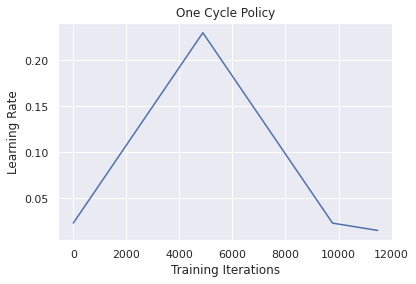

In [ ]:
plt.plot(ocp.history['iterations'], ocp.history['lr'])
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("One Cycle Policy")
plt.show()

#$ Learning \, Range \, Test $#
$ Here \, some \, layers \, of \, the \, pre-trained \, model \, are \, set \, as \, trainable \, along \, with \, the \, classifier-block$

In [ ]:
new_model.save_weights('bottleneck_model.h5')

In [ ]:
final_base_model=(resn.ResNet50(weights='imagenet', 
                       include_top=False, 
                       input_shape=(32, 32, 3)))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning:

The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.



In [ ]:
last_1 = final_base_model.layers[-1].output

In [ ]:
last_1=GlobalAveragePooling2D()(last_1)
x_1=Dense(512,name='dense_top_1')(last_1)
x_1=BatchNormalization(name='batch_norm_top_1')(x_1)
x_1=Activation('relu',name='activation_top_1')(x_1)
x_1=Dense(256, activation='relu',name='dense_top_2')(x_1)
x_1=BatchNormalization(name='batch_norm_top_2')(x_1)
x_1=Activation('relu',name='activation_top_2')(x_1)
pred_1=Dense(6, activation='softmax',name='dense_top_3')(x_1)
final_model=Model(final_base_model.input,pred_1)

In [ ]:
final_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

Loading the weights of the previously trained model

In [ ]:
final_model.load_weights('bottleneck_model.h5')

In [ ]:
for layer in final_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
for layer in final_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f2157e2c358> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f2157e2c3c8> False
<keras.layers.convolutional.Conv2D object at 0x7f2157e2c518> False
<keras.layers.normalization.BatchNormalization object at 0x7f2157e2c588> True
<keras.layers.core.Activation object at 0x7f2157e2c630> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f2157e2cda0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f2157e2ccf8> False
<keras.layers.convolutional.Conv2D object at 0x7f2157e2d4e0> False
<keras.layers.normalization.BatchNormalization object at 0x7f2157e3f400> True
<keras.layers.core.Activation object at 0x7f2157e3f470> False
<keras.layers.convolutional.Conv2D object at 0x7f2157e4d748> False
<keras.layers.normalization.BatchNormalization object at 0x7f2157de0da0> True
<keras.layers.core.Activation object at 0x7f2157de7a20> False
<keras.layers.convolutional.Conv2D object at 0x7f2157dfceb8> False
<keras.layers.convolutional.

In [ ]:
for i in range(-19,0):
  final_model.layers[i].trainable = True

In [ ]:
for layer in final_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f2157e2c358> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f2157e2c3c8> False
<keras.layers.convolutional.Conv2D object at 0x7f2157e2c518> False
<keras.layers.normalization.BatchNormalization object at 0x7f2157e2c588> True
<keras.layers.core.Activation object at 0x7f2157e2c630> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f2157e2cda0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f2157e2ccf8> False
<keras.layers.convolutional.Conv2D object at 0x7f2157e2d4e0> False
<keras.layers.normalization.BatchNormalization object at 0x7f2157e3f400> True
<keras.layers.core.Activation object at 0x7f2157e3f470> False
<keras.layers.convolutional.Conv2D object at 0x7f2157e4d748> False
<keras.layers.normalization.BatchNormalization object at 0x7f2157de0da0> True
<keras.layers.core.Activation object at 0x7f2157de7a20> False
<keras.layers.convolutional.Conv2D object at 0x7f2157dfceb8> False
<keras.layers.convolutional.

In [ ]:
final_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
final_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
clr = CyclicLR(base_lr=1e-5, max_lr=3,
                        step_size=4*2295)

In [ ]:
history = new_model.fit(x_train,
                        y_train, 
                        batch_size=120, 
                        epochs=4,
                        validation_data=(x_val,y_val),
                        callbacks=[clr], 
                        verbose=1)

Train on 275400 samples, validate on 48600 samples
Epoch 1/4
275400/275400 [==============================] - 1099s 4ms/step - loss: 0.2016 - accuracy: 0.9450 - val_loss: 0.1911 - val_accuracy: 0.9342
Epoch 2/4
275400/275400 [==============================] - 1097s 4ms/step - loss: 1.4309 - accuracy: 0.5578 - val_loss: 1.4722 - val_accuracy: 0.3902
Epoch 3/4
275400/275400 [==============================] - 1112s 4ms/step - loss: 9.3812 - accuracy: 0.3861 - val_loss: 3645.6601 - val_accuracy: 0.3881
Epoch 4/4
275400/275400 [==============================] - 1105s 4ms/step - loss: 4.4651 - accuracy: 0.3340 - val_loss: 1.5238 - val_accuracy: 0.3714


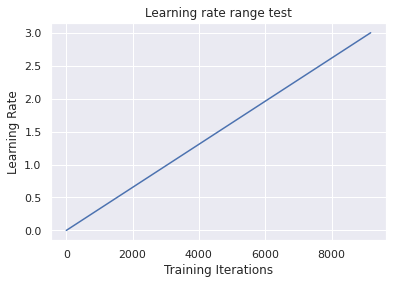

In [ ]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("Learning rate range test")
plt.plot(clr.history['iterations'], clr.history['lr'])

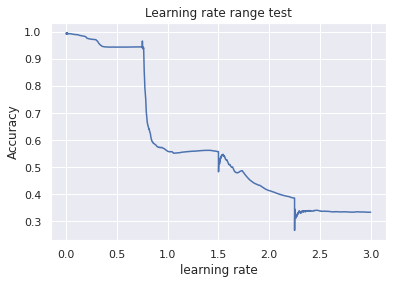

In [ ]:
h = clr.history
lr = h['lr']
acc = h['accuracy']
plt.xlabel('learning rate')
plt.ylabel('Accuracy')
plt.title("Learning rate range test")
plt.plot(lr,acc)

In [ ]:
for i in range(5000):
  print(lr[i],acc[i])

Streaming output truncated to the last 5000 lines.
0.0003367963 0.99583334
0.0006635926 0.99722224
0.0009903889 0.99583334
0.0013171852 0.99666667
0.0016439814 0.99444443
0.0019707778 0.99523807
0.0022975742 0.9947917
0.0026243704 0.9953704
0.0029511666 0.99583334
0.003277963 0.9962121
0.0036047592 0.99583334
0.0039315554 0.99551284
0.004258352 0.99523807
0.0045851483 0.995
0.0049119443 0.9947917
0.0052387407 0.99460787
0.005565537 0.99444443
0.005892333 0.9942982
0.0062191295 0.9941667
0.006545926 0.99444443
0.0068727224 0.994697
0.0071995184 0.9945652
0.007526315 0.9947917
0.007853111 0.995
0.008179908 0.9951923
0.008506704 0.99475306
0.0088335 0.99494046
0.009160296 0.9951149
0.0094870925 0.995
0.009813889 0.9951613
0.010140685 0.9950521
0.010467482 0.995202
0.010794278 0.99509805
0.011121074 0.99523807
0.01144787 0.99467593
0.011774667 0.9945946
0.012101463 0.99451756
0.0124282595 0.99401706
0.012755056 0.99395835
0.013081851 0.9941057
0.013408648 0.9936508
0.013735444 0.99360466
0

#$ Training \, the \, model $#
$ Here \, some \, layers \, of \, the \, pre-trained \, model \, are \, set \, as \, trainable \, along \, with \, the \, classifier-block$

In [ ]:
final_base_model=(resn.ResNet50(weights='imagenet', 
                       include_top=False, 
                       input_shape=(32, 32, 3)))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning:

The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.



94658560/94653016 [==============================] - 1s 0us/step


In [ ]:
last_1 = final_base_model.layers[-1].output

In [ ]:
last_1=GlobalAveragePooling2D()(last_1)
x_1=Dense(512,name='dense_top_1')(last_1)
x_1=BatchNormalization(name='batch_norm_top_1')(x_1)
x_1=Activation('relu',name='activation_top_1')(x_1)
x_1=Dense(256, activation='relu',name='dense_top_2')(x_1)
x_1=BatchNormalization(name='batch_norm_top_2')(x_1)
x_1=Activation('relu',name='activation_top_2')(x_1)
pred_1=Dense(6, activation='softmax',name='dense_top_3')(x_1)
final_model=Model(final_base_model.input,pred_1)

In [ ]:
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
final_model.load_weights('bottleneck_model.h5')

In [ ]:
for layer in final_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
for layer in final_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f60e56ef438> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f60e56ef978> False
<keras.layers.convolutional.Conv2D object at 0x7f60e56ef860> False
<keras.layers.normalization.BatchNormalization object at 0x7f60e56ef748> True
<keras.layers.core.Activation object at 0x7f60e56efc88> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f60e56fbb00> False
<keras.layers.pooling.MaxPooling2D object at 0x7f60e56fb908> False
<keras.layers.convolutional.Conv2D object at 0x7f60e56fbb70> False
<keras.layers.normalization.BatchNormalization object at 0x7f60e7050ba8> True
<keras.layers.core.Activation object at 0x7f60e699bda0> False
<keras.layers.convolutional.Conv2D object at 0x7f60e69c34e0> False
<keras.layers.normalization.BatchNormalization object at 0x7f60cc8fdda0> True
<keras.layers.core.Activation object at 0x7f60cc8d6eb8> False
<keras.layers.convolutional.Conv2D object at 0x7f60cc8ecd30> False
<keras.layers.convolutional.

In [ ]:
for i in range(-19,0):
  final_model.layers[i].trainable = True

In [ ]:
for layer in final_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f60e56ef438> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f60e56ef978> False
<keras.layers.convolutional.Conv2D object at 0x7f60e56ef860> False
<keras.layers.normalization.BatchNormalization object at 0x7f60e56ef748> True
<keras.layers.core.Activation object at 0x7f60e56efc88> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f60e56fbb00> False
<keras.layers.pooling.MaxPooling2D object at 0x7f60e56fb908> False
<keras.layers.convolutional.Conv2D object at 0x7f60e56fbb70> False
<keras.layers.normalization.BatchNormalization object at 0x7f60e7050ba8> True
<keras.layers.core.Activation object at 0x7f60e699bda0> False
<keras.layers.convolutional.Conv2D object at 0x7f60e69c34e0> False
<keras.layers.normalization.BatchNormalization object at 0x7f60cc8fdda0> True
<keras.layers.core.Activation object at 0x7f60cc8d6eb8> False
<keras.layers.convolutional.Conv2D object at 0x7f60cc8ecd30> False
<keras.layers.convolutional.

In [ ]:
final_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
batch_size = 120
epochs = 10
max_lr = 0.097
base_lr = max_lr/10
max_m = 0
base_m = 0

cyclical_momentum = False
augment = False
cycles = 2.35

iterations = round(len(x_train)/batch_size*epochs)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)

In [ ]:
ocp =  Onecycle(base_lr=base_lr,
                max_lr=max_lr,
                step_size=step_size,
                max_m=max_m,
                base_m=base_m,
                cyclical_momentum=cyclical_momentum)

Training using one-cycle-policy using the parameters as mentioned above

In [ ]:
history = final_model.fit(x_train,
                        y_train,
                        batch_size=120,
                        epochs=10,
                        verbose=1,
                        callbacks=[ocp],
                        validation_data=(x_val,y_val))

Train on 275400 samples, validate on 48600 samples
Epoch 1/10
275400/275400 [==============================] - 1051s 4ms/step - loss: 0.0315 - accuracy: 0.9906 - val_loss: 0.0239 - val_accuracy: 0.9923
Epoch 2/10
275400/275400 [==============================] - 1034s 4ms/step - loss: 0.0242 - accuracy: 0.9920 - val_loss: 0.0215 - val_accuracy: 0.9917
Epoch 3/10
275400/275400 [==============================] - 1033s 4ms/step - loss: 0.0283 - accuracy: 0.9906 - val_loss: 0.0365 - val_accuracy: 0.9871
Epoch 4/10
275400/275400 [==============================] - 1038s 4ms/step - loss: 0.0301 - accuracy: 0.9903 - val_loss: 0.0266 - val_accuracy: 0.9913
Epoch 5/10
275400/275400 [==============================] - 1033s 4ms/step - loss: 0.0295 - accuracy: 0.9906 - val_loss: 0.0242 - val_accuracy: 0.9915
Epoch 6/10
275400/275400 [==============================] - 1043s 4ms/step - loss: 0.0221 - accuracy: 0.9927 - val_loss: 0.0258 - val_accuracy: 0.9908
Epoch 7/10
275400/275400 [=================

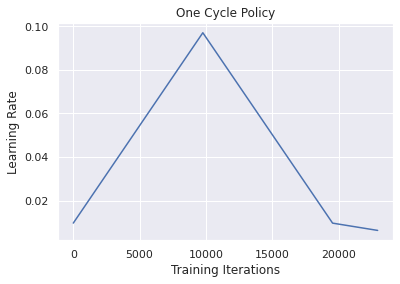

In [ ]:
plt.plot(ocp.history['iterations'], ocp.history['lr'])
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("One Cycle Policy")
plt.show()

In [ ]:
final_model.save_weights('final_weights.h5')

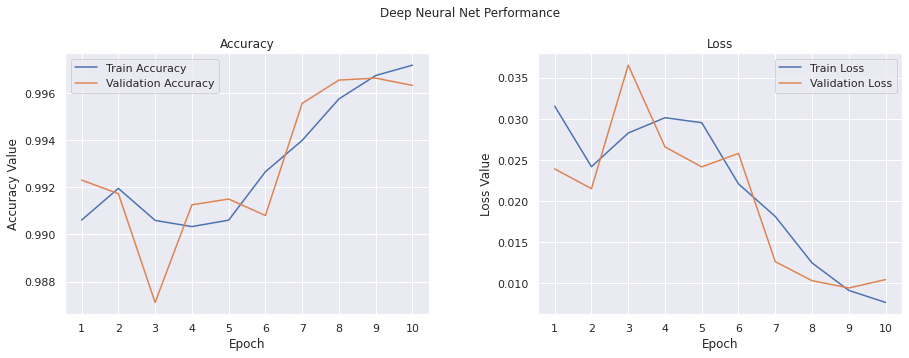

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,10+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

#$Testing \, the \, model$

In [ ]:
print("test accuracy = ",final_model.evaluate(x_test,y_test))
y_pred_class = final_model.predict(x_test, verbose=1)

81000/81000 [==============================] - 129s 2ms/step
test accuracy =  [0.010077866672268438, 0.9965432286262512]
81000/81000 [==============================] - 126s 2ms/step


In [ ]:
print('f1_score =',f1_score(np.argmax(y_test,axis=-1),np.argmax(y_pred_class,axis=-1),average='weighted'))

f1_score = 0.9965461848407303


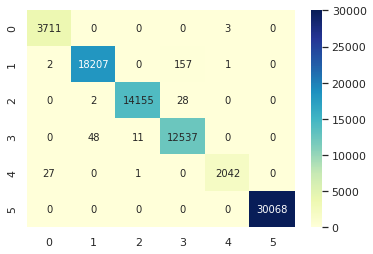

In [ ]:
cm=confusion_matrix(np.argmax(y_test,axis=-1),np.argmax(y_pred_class,axis=-1))
fig = go.Figure(data=[go.Table(header=dict(values=['Confusion Matrix ','1','2','3','4','5','6']),
                 cells=dict(values=[['predicted as 1','predicted as 2','predicted as 3','predicted as 4','predicted as 5',
                                     'predicted as 6'],cm[0,:],cm[1,:],cm[2,:],cm[3,:],
                                    cm[4,:],cm[5,:]]))])
fig.show()
ax = sns.heatmap(cm, annot=True,cmap="YlGnBu", fmt="d")

In [ ]:
label_names=['barren land', 'trees', 'grassland', 'roads', 'buildings', 'water bodies']
print(classification_report(np.argmax(y_test,axis=-1),np.argmax(y_pred_class,axis=-1),
	target_names=label_names))

              precision    recall  f1-score   support

 barren land       0.99      1.00      1.00      3714
       trees       1.00      0.99      0.99     18367
   grassland       1.00      1.00      1.00     14185
       roads       0.99      1.00      0.99     12596
   buildings       1.00      0.99      0.99      2070
water bodies       1.00      1.00      1.00     30068

    accuracy                           1.00     81000
   macro avg       1.00      1.00      1.00     81000
weighted avg       1.00      1.00      1.00     81000

